**Nội dung bài thực hành**

Người học tiếp cận và giải quyết bài toán dự báo chuỗi thời gian (Time Series Forecasting) bang mô hình LSTM. Sau khi thực hành, người học có khả năng:
1. Sử dụng được Keras để cài đặt các mô hình LSTM

2. Áp dụng được LSTM cho bài toán dự báo chuỗi thời gian


*   Huấn luyện mô hình
*   Đánh gía mô hình


3. Cải tiến được mô hình dự báo chuỗi thời gian

### Download data

In [1]:
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip

--2019-03-30 03:29:14--  http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.249
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.249|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20640916 (20M) [application/zip]
Saving to: 'household_power_consumption.zip'

household_power_con 100%[===================>]  19.68M  2.49MB/s    in 9.6s    

2019-03-30 03:29:24 (2.06 MB/s) - 'household_power_consumption.zip' saved [20640916/20640916]



In [2]:
# unzip downloaded file

import zipfile
zip_ref = zipfile.ZipFile('household_power_consumption.zip', 'r')
zip_ref.extractall('.')
zip_ref.close()

### Đọc dữ liệu

Mô tả chi tiết dữ liệu ở đây http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption 
* 1.date: Ngày ở định dạng dd / mm / yyyy

* 2.time: thời gian ở định dạng hh: mm: ss

* 3.global_active_power: công suất điện động trung bình/phút của hộ gia đình (kilowatt)

* 4.global_reactive_power: công suất điện kháng trung bình/phút của hộ gia đình (kilowatt)

* 5.vol thế: điện áp trung bình /phút (tính bằng volt)

* 6.global_int: cường độ dòng trung bình /phút toàn cầu của hộ gia đình (ampere)

* 7.sub_metering_1: đo lường năng lượng phụ số 1 (tính theo giờ năng lượng hoạt động). Nó tương ứng với nhà bếp, gồm chủ yếu là máy rửa chén, lò nướng và lò vi sóng.

* 8.sub_metering_2: đo lường năng lượng phụ số 2 (tính theo giờ năng lượng hoạt động). Nó tương ứng với phòng giặt, gồm máy giặt, máy sấy quần áo, tủ lạnh và đèn.

* 9.sub_metering_3: đo lường năng lượng phụ số 3 (tính theo giờ năng lượng hoạt động). Nó tương ứng với máy nước nóng  và điều hòa không khí

**Bài toán**: Dự đoán công suất điện động(global_active_power) gia đình tại thời điểm hiện tại dựa trên công suất điện động và các feature khác ở các thời điểm ngay truớc nó
Xây dựng mô hình gồm có:
* Input: các feature tại thời điểm trong quá khứ
* Output: công suất điện động ở thời điểm hiện tại
* Hàm lỗi sử dụng trong lúc huấn luyện là hàm Sai số toàn phương trung bình (mse - mean square error) : $$ MSE = \frac{1}{n}\sum_{t=1}(Y-\hat Y) $$
* Độ đo dùng để đánh giá mô hình là RMSE: $$RMSE = \sqrt{\frac{1}{n}\sum_{t=1}^{n}(Y - \hat Y)^2}$$

In [1]:
import pandas as pd
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')


df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtypes: float64(7)
memory usage: 126.7 MB


In [3]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Lấp các ô có giá trị null bằng giá trị trung bình của các hàng còn lại

In [4]:
for j in range(0,7):
    df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

### Biểu diễn dữ liệu

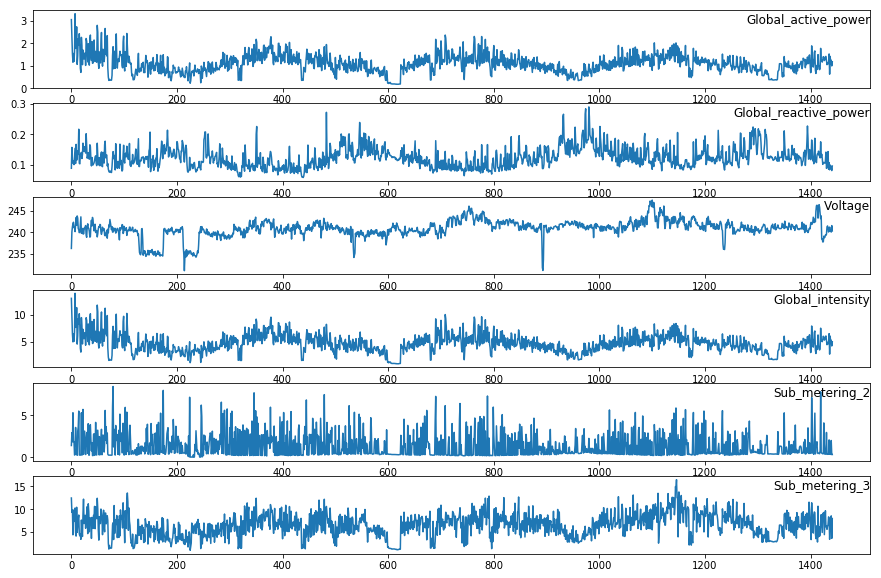

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

nhóm dữ liệu thành từng tuần và tính trung bình của mỗi tuần

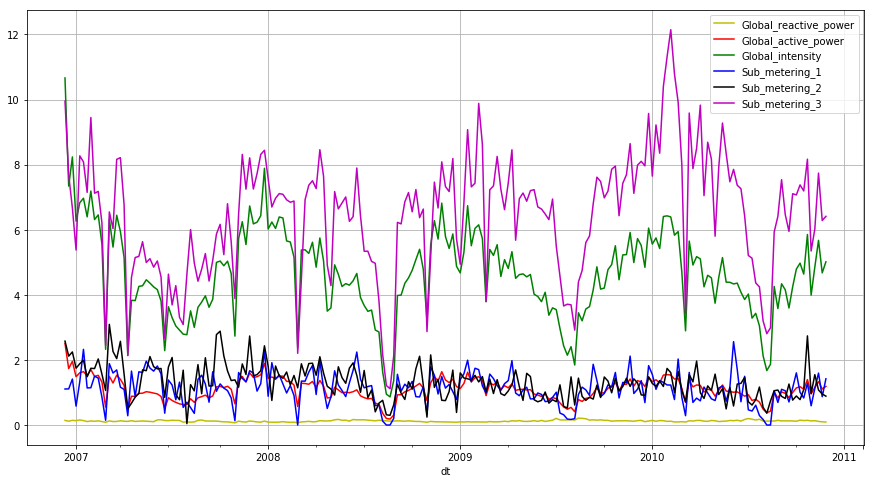

In [6]:
plt.figure(figsize=(15,8))

df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Sub_metering_2.resample('W').mean().plot(color='k', legend=True)
df.Sub_metering_3.resample('W').mean().plot(color='m', legend=True)
plt.grid()
plt.show()

### Chuan bi du lieu

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, label_col=0, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i)[label_col])
        if i == 0:
            names.append('var%d(t)' % (label_col))
        else:
            names.append('var%d(t+%d)' % (j+1, i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Nhom du lieu theo gio

In [8]:
df_resample = df.resample('H').mean()
df_resample.shape

(34589, 7)

In [9]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)

# drop columns we don't want to predict
#reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34582 entries, 7 to 34588
Data columns (total 50 columns):
var1(t-7)    34582 non-null float64
var2(t-7)    34582 non-null float64
var3(t-7)    34582 non-null float64
var4(t-7)    34582 non-null float64
var5(t-7)    34582 non-null float64
var6(t-7)    34582 non-null float64
var7(t-7)    34582 non-null float64
var1(t-6)    34582 non-null float64
var2(t-6)    34582 non-null float64
var3(t-6)    34582 non-null float64
var4(t-6)    34582 non-null float64
var5(t-6)    34582 non-null float64
var6(t-6)    34582 non-null float64
var7(t-6)    34582 non-null float64
var1(t-5)    34582 non-null float64
var2(t-5)    34582 non-null float64
var3(t-5)    34582 non-null float64
var4(t-5)    34582 non-null float64
var5(t-5)    34582 non-null float64
var6(t-5)    34582 non-null float64
var7(t-5)    34582 non-null float64
var1(t-4)    34582 non-null float64
var2(t-4)    34582 non-null float64
var3(t-4)    34582 non-null float64
var4(t-4)    34582 non-null

#### Train test split

In [10]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24*2
train = values[:n_train_time, :]
test = values[n_train_time:, :]

##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 7, -1))
test_X = test_X.reshape((test_X.shape[0], 7, -1))
print("Train on {} samples, test on {} samples".format(train_X.shape[0], test_X.shape[0])) 

Train on 17520 samples, test on 17062 samples


In [11]:
print(train_X.shape)

(17520, 7, 7)


#### Model

In [57]:
from keras.layers.recurrent import LSTM
from keras.layers import CuDNNLSTM # comment dong nay neu may ban khong ho tro CuDNN
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Dense, Dropout

from keras import backend as K

# Config
hidden_dim = 100
dropout = 0.2
loss_fn = 'mean_squared_error'
epochs = 50
batch_size = 70
opt = "adam"
timesteps = 7
lstm = CuDNNLSTM # chuyen dong nay thanh LSTM neu may ban khong ho tro CuDNN

In [58]:
x = Input(name='input', shape=(timesteps,7), dtype='float32')
x_lstm = lstm(hidden_dim, input_shape=(timesteps, 7), 
              return_sequences=False, name='lstm')(x)
x_dropout = Dropout(dropout)(x_lstm)
y = Dense(1)(x_dropout)
model = Model(inputs=x, outputs=y)
model.compile(loss=loss_fn, optimizer=opt)

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 7, 7)              0         
_________________________________________________________________
lstm (CuDNNLSTM)             (None, 100)               43600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


In [60]:
history = model.fit(train_X, train_y, 
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(test_X, test_y), shuffle=False)

Train on 17520 samples, validate on 17062 samples
Epoch 1/50
17520/17520 [==============================] - 3s 177us/step - loss: 0.0151 - val_loss: 0.0119
Epoch 2/50
17520/17520 [==============================] - 1s 74us/step - loss: 0.0110 - val_loss: 0.0097
Epoch 3/50
17520/17520 [==============================] - 1s 73us/step - loss: 0.0101 - val_loss: 0.0091
Epoch 4/50
17520/17520 [==============================] - 1s 72us/step - loss: 0.0098 - val_loss: 0.0086
Epoch 5/50
17520/17520 [==============================] - 1s 72us/step - loss: 0.0097 - val_loss: 0.0085
Epoch 6/50
17520/17520 [==============================] - 1s 73us/step - loss: 0.0096 - val_loss: 0.0082
Epoch 7/50
17520/17520 [==============================] - 1s 72us/step - loss: 0.0095 - val_loss: 0.0082
Epoch 8/50
17520/17520 [==============================] - 1s 74us/step - loss: 0.0095 - val_loss: 0.0082
Epoch 9/50
17520/17520 [==============================] - 1s 71us/step - loss: 0.0094 - val_loss: 0.0079
Epoc

### Kết quả

In [61]:
import numpy as np
from sklearn.metrics import mean_squared_error

yhat = model.predict(test_X)
p_test_X = test_X[:,-1,:].reshape((test_X.shape[0], 7))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, p_test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, p_test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# ham loi
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.572


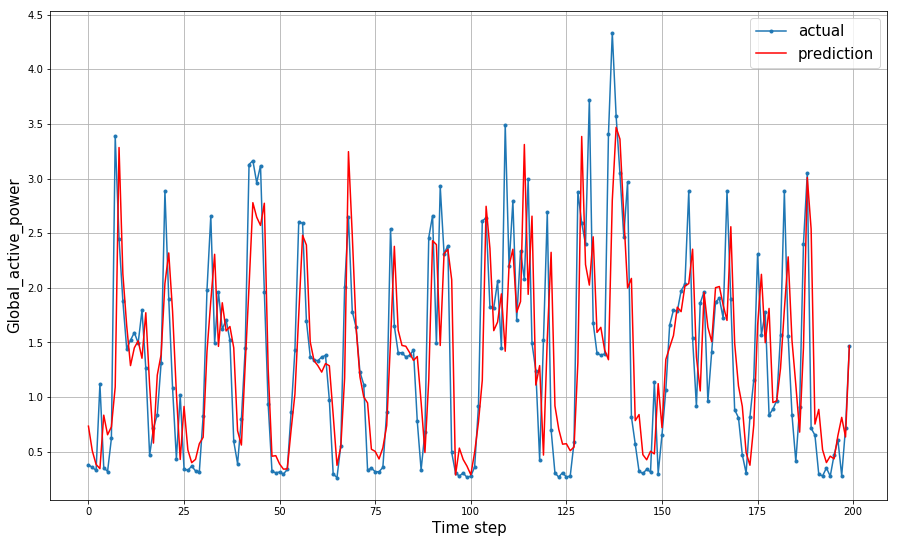

In [62]:
plt.figure(figsize=(15,9))
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()

### Finetuning Model
Thay đổi các siêu tham số (hyper parameter), thêm layer vào mô hình để tăng hiệu suất của mô hình

In [51]:
K.clear_session()

In [52]:
x = Input(name='input', shape=(timesteps,7), dtype='float32')
x_lstm = lstm(50, input_shape=(timesteps, 7), 
              return_sequences=True, name='lstm')(x)
x_dropout = Dropout(0.5)(x_lstm)
x_lstm = lstm(100, input_shape=(timesteps, 7), 
              return_sequences=False, name='lstm_2')(x_dropout)
x_dropout = Dropout(0.5)(x_lstm)
x_den = Dense(200, activation="relu")(x_dropout) 
y = Dense(1, activation="linear")(x_den)
model = Model(inputs=x, outputs=y)
model.compile(loss=loss_fn, optimizer=opt)

In [53]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 7, 7)              0         
_________________________________________________________________
lstm (CuDNNLSTM)             (None, 7, 50)             11800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (CuDNNLSTM)           (None, 100)               60800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total para

In [54]:
history = model.fit(train_X, train_y, 
                    epochs=50, batch_size=batch_size, 
                    validation_data=(test_X, test_y), shuffle=False)

Train on 17520 samples, validate on 17062 samples
Epoch 1/50
17520/17520 [==============================] - 4s 245us/step - loss: 0.0196 - val_loss: 0.0110
Epoch 2/50
17520/17520 [==============================] - 2s 112us/step - loss: 0.0134 - val_loss: 0.0111
Epoch 3/50
17520/17520 [==============================] - 2s 111us/step - loss: 0.0114 - val_loss: 0.0106
Epoch 4/50
17520/17520 [==============================] - 2s 110us/step - loss: 0.0106 - val_loss: 0.0103
Epoch 5/50
17520/17520 [==============================] - 2s 109us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/50
17520/17520 [==============================] - 2s 112us/step - loss: 0.0101 - val_loss: 0.0095
Epoch 7/50
17520/17520 [==============================] - 2s 111us/step - loss: 0.0100 - val_loss: 0.0094
Epoch 8/50
17520/17520 [==============================] - 2s 110us/step - loss: 0.0099 - val_loss: 0.0093
Epoch 9/50
17520/17520 [==============================] - 2s 115us/step - loss: 0.0098 - val_loss: 0.0

In [55]:
import numpy as np
from sklearn.metrics import mean_squared_error

yhat = model.predict(test_X)
p_test_X = test_X[:,-1,:].reshape((test_X.shape[0], 7))

# invert scaling for forecast
inv_yhat = np.concatenate((yhat, p_test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, p_test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# ham loi
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.554


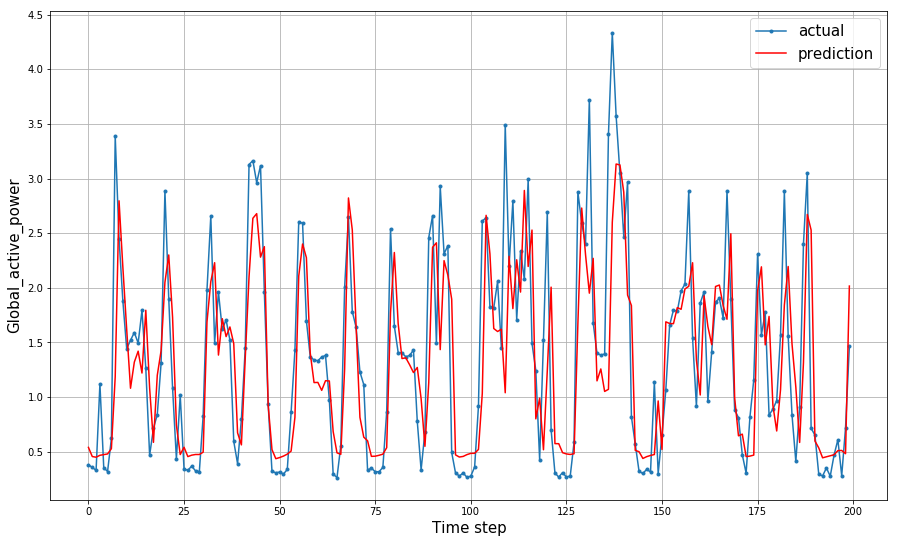

In [56]:
plt.figure(figsize=(15,9))
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.grid()
plt.show()